# DIMENSION REDUCTION WITH AUTOENCODERS

**Changes**
* layers.Dropout(0.4),

<font size="5">*Joe Hellerstein*, Research Scientist, eScience Institute</font>

**Motivation**

We often want to reduce the dimensionality of data
* *Data Analysis*: Focus on a few important variables
* *Dynamical Systems*: Visualize dynamics (e.g., in 2d)
* *Image Processing*: Compress data into essential pixels

Dimension reduction is crucial in machine learning for simplifying complex data sets (Van Der Maaten et al. 2009), reducing computational complexity (Ray et al. 2021), and mitigating the curse of dimensionality (Talpur et al. 2023), ultimately improving model performance and interpretability. Dimension reduction encompasses two primary approaches: feature selection (Solorio-Fernández et al. 2022), which involves choosing a subset of the most informative features from the original data-set to reduce dimensionality while maintaining interpretability; and feature extraction (Li et al. 2022), a method where new, lower-dimensional features are derived from the original data to capture essential patterns and relationships.

Autoencoders and their applications in machine learning: a survey  Kamal Berahmand1 · Fatemeh Daneshfar2 · Elaheh Sadat Salehi3 · Yuefeng Li1 · Yue Xu1, Artificial Intelligence Review (2024)

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/feature_extraction.png" 
         alt="Types of feature extractiom."
         width="600">

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/generic_autoencoder.png" 
         alt="Generic autoencoder"
         width="400">

* Same number of nodes in the input and output layers
* Hidden layer has fewer nodes
* May be many hidden layers.
* If many hidden layers.
* * An even number. First half is **encoder**; second is **decoder**

We will focus on the task of compression initially.

# Preliminaries

In [1]:
import collections
import io
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
import pandas as pd
import os
from typing import Tuple, List, Optional
from torchvision import datasets
import zipfile

# Helpers

## Constants

In [2]:
ANIMALS_PATH = "animals.pkl"
MNIST_PATH = "mnist.pkl"
MODEL_DIR = "."

In [3]:
TrainTestData = collections.namedtuple('TrainTestData', ['x_train', 'label_train', 'x_test', 'label_test', 'class_names'])
# x_train: np.ndarray (training data)
# label_train: np.ndarray (training labels)
# x_test: np.ndarray (test data)
# label_test: np.ndarray (test labels)
# class_names: List[str] (class names)

## getPklAnimals

In [4]:
def getPklAnimals() -> TrainTestData:
    """Recovers Animals image data from pickle files, or pickles the data if not present.

    Returns:
        TrainTestData: A named tuple containing training and test data and labels.
    """
    ##
    data_dir = "/Users/jlheller/home/Technical/repos/pixel_proficiency/data/animals"
    def getData(data_type: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        dataset = datasets.STL10(root=data_dir, split=data_type, download=True)
        class_names = dataset.classes  # List of class names
        images = []
        labels = []
        for img, label in dataset:
            images.append(np.array(img))
            labels.append(label)
        images_array = np.stack(images)  # Shape: (N, 96, 96, 3)
        labels_array = np.array(labels)  # Shape: (N,)
        return images_array, labels_array, class_names
    ##
    if not os.path.exists(ANIMALS_PATH):
        print("***Pickling Animals data...")
        train_image_arr, train_label_arr, class_names = getData('train')
        test_image_arr, test_label_arr, class_names = getData('test')
        data = (train_image_arr, train_label_arr, test_image_arr, test_label_arr, class_names)
        with open(ANIMALS_PATH, 'wb') as f:
            pickle.dump(data, f)
    else:
        print("***Unpickling Animals data...")
        with open(ANIMALS_PATH, 'rb') as f:  # type: ignore
            train_image_arr, train_label_arr, test_image_arr, test_label_arr, class_names = pickle.load(f)
    return TrainTestData(train_image_arr, train_label_arr, test_image_arr, test_label_arr, class_names)

In [5]:
X_ANIMAL_TRAIN, LABEL_ANIMAL_TRAIN, X_ANIMAL_TEST, LABEL_ANIMAL_TEST, ANIMAL_CLASS_NAMES = getPklAnimals()

***Unpickling Animals data...


In [6]:
np.shape(X_ANIMAL_TRAIN)

(5000, 96, 96, 3)

## getPklMNIST

In [7]:

def getPklMNIST() -> TrainTestData:
    """Recovers MNIST image data from pickle files, or pickles the data if not present.

    Returns:
        TrainTestData: A named tuple containing training and test data and labels.
    """
    if not os.path.exists(MNIST_PATH):
        print("***Pickling MNIST data...")
        (x_train, label_train), (x_test, label_test) = mnist.load_data()
        data = (x_train, label_train, x_test, label_test)
        with open(MNIST_PATH, 'wb') as f:
            pickle.dump(data, f)
    else:
        print("***Unpickling MNIST data...")
        with open(MNIST_PATH, 'rb') as f:
            x_train, label_train, x_test, label_test = pickle.load(f)
    class_names = [str(i) for i in range(10)]
    return TrainTestData(x_train, label_train, x_test, label_test, class_names)

In [8]:
X_MNIST_TRAIN, LABEL_MNIST_TRAIN, X_MNIST_TEST, LABEL_MNIST_TEST, MNIST_CLASS_NAMES = getPklMNIST()

***Unpickling MNIST data...


In [9]:
np.shape(X_MNIST_TRAIN)

(60000, 28, 28)

## visualize

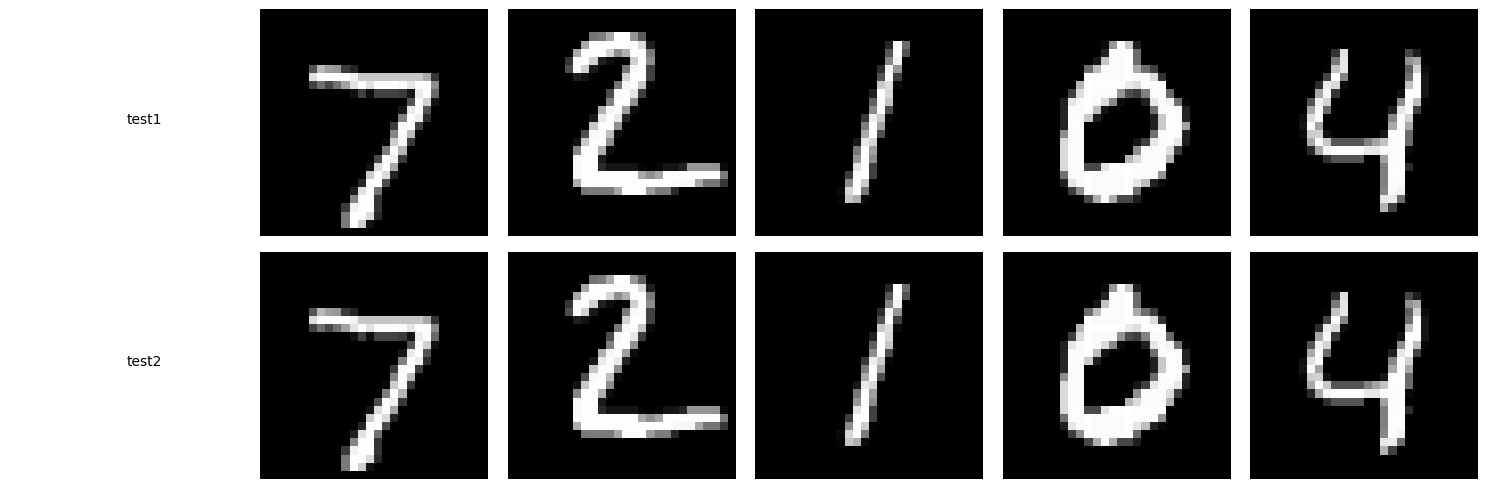

OK!


In [10]:
def visualize(arrs: np.ndarray, num_image: int, titles: str = "", figsize=(15, 5)):
    # Displays one or more digits
    num_row = len(arrs)
    _, axes =  plt.subplots(num_row, num_image + 1, figsize=figsize)
    for irow, arr in enumerate(arrs):
        ax = axes[irow, 0]
        ax.text(0.5, 0.5, titles[irow])
        ax.axis('off')
        for i in range(num_image):
            # Original images
            #ax = plt.subplot(1, num_image + 1, i + 2)
            ax = axes[irow, i+1]
            ax.imshow(arr[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Test
visualize([X_MNIST_TEST, X_MNIST_TEST], 5, titles=["test1", "test2"])
#plt.close()
print("OK!")

## zipCompressArray

In [11]:
# Method 1: Using BytesIO with zipfile
def zipCompressArray(arr):
    """Compress numpy array to zip in memory"""
    # Create in-memory bytes buffer
    zip_buffer = io.BytesIO()
    
    # Create zip file in memory
    with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        # Save array to bytes
        arr_bytes = io.BytesIO()
        np.save(arr_bytes, arr)
        arr_bytes.seek(0)
        
        # Write to zip
        zip_file.writestr('array.npy', arr_bytes.read())
    
    # Get compressed data
    zip_buffer.seek(0)
    return zip_buffer

# Test
arr = np.random.rand(1000, 1000)
compressed = zipCompressArray(arr)
assert(len(compressed.getvalue()) < arr.nbytes)
print("OK!")

OK!


## dictToStr

In [12]:

def dictToStr(dct: dict)->str:
    result = ""
    sep = ""
    for key, value in dct.items():
        if len(result) > 0:
            sep = "-"
        result = result + sep + key + "_" + str(value)
    return result

## AbstractAutoencoder

In [13]:

import collections
import json
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau #  type: ignore
import matplotlib.pyplot as plt#  type: ignore
import matplotlib.cm as cm
import numpy as np#  type: ignore
import os
import pandas as pd#  type: ignore
from tensorflow import keras #  type: ignore
from tensorflow.keras.models import load_model # type: ignore
from typing import Tuple, List, Optional


MAX_EPOCH = 1000   # Maximum number of epochs for training

class AbstractAutoencoder(object):

    def __init__(self, base_path: str, is_delete_serializations: bool=True):
        """Initializes the abstract autoencoder.
        Args:
            base_path (str): Base path for model serialization.
            is_delete_serializations (bool, optional): Whether to delete existing serializations. Defaults to True.
        """
        self.base_path = base_path
        self.png_pat = os.path.join(base_path, "%s.png") # pattern for naming plots
        self.autoencoder, self.encoder, self.decoder, self.history_dct =  \
                self.deserializeAll(base_path=base_path)
        self.is_fit = False
        if is_delete_serializations or self.autoencoder is None:
            self.print("...deleting existing serializations (if any) and rebuilding the model.")
            self.deleteSerializations(base_path=base_path)
            self.autoencoder, self.encoder, self.decoder, self.history_dct =  \
                    self._build()
        else:
            self.print("...loaded existing serializations.")
            self.is_fit = True

    @property
    def compression_factor(self) -> float:
        raise NotImplementedError("Subclasses must implement compression_factor property")
    
    #property
    def context_dct(self) -> dict:
        # Describes the parameters used to build the model.
        raise NotImplementedError("Subclasses must implement context_dct property")
    
    def deleteSerializations(self, base_path: Optional[str] = None) -> None:
        """Deletes the serialized models and history files.

        Args:
            base_path (str, optional): Base path for model serialization.
                                        If None, uses self.base_path. Defaults to None.
        """
        if base_path is None:
            base_path = self.base_path
        autoencoder_path, encoder_path, decoder_path, history_path  = \
                self._makeSerializationPaths(base_path)
        for path in [autoencoder_path, encoder_path, decoder_path, history_path]:
            if os.path.exists(path):
                os.remove(path)

    def _build(self) -> Tuple[keras.Model, keras.Model, keras.Model, dict]:
        """Builds the autoencoder, encoder, and decoder models.

        Returns:
            autoencoder, encoder, decoder models and history dictionary
        """
        raise NotImplementedError("Subclasses must implement _build method")

    def fit(self, 
            x_train: np.ndarray,
            num_epoch: int,
            batch_size: int,
            validation_data: np.ndarray,
            verbose: int=1) -> None:
        """Fits the autoencoder model to the training data. Checkpoint the model.
        Normalizes the data to [0, 1] before training.

        Args:
            x_train (np.ndarray): Training data.
            num_epoch (int): Number of epochs to train.
            batch_size (int): Batch size for training.
            validation_data (np.ndarray): Validation data.
            verbose (int, optional): Verbosity level. Defaults to 1.
        """
        # Train the autoencoder
        if self.is_fit:
            print("Model is already fit. Skipping training.")
            return
        # Create a ModelCheckpoint callback
        callbacks = [
            ModelCheckpoint(
                os.path.join(MODEL_DIR, 'best_autoencoder.keras'),
                monitor='val_loss',
                save_best_only=True,
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                # Use min_delta 0 since we don't know the right units to detect improvement
                min_delta=0,  # type: ignore
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,        # reduce LR by half
                patience=10,        # after 5 epochs without improvement
                min_lr=1e-7,
                verbose=1
            )
        ]
        # Normalize the data
        x_train_nrml = self.normalizeImages(x_train)
        x_validation_nrml = self.normalizeImages(validation_data)
        self.history = self.autoencoder.fit(
            x_train_nrml, x_train_nrml,
            epochs=num_epoch,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(x_validation_nrml, x_validation_nrml),
            callbacks=callbacks,
            verbose=verbose
        )
        self.history_dct = self.history.history
        # Load the best model after training
        self.serializeAll()
    
    def summarize(self) -> None:
        # Prints a summary of the autoencoder model.
        self.autoencoder.summary()
    
    def predict(self, image_arr: np.ndarray,
            predictor_type: str = "autoencoder") -> np.ndarray:
        """Generates reconstructed images from the autoencoder.

        Args:
            image_arr (np.ndarray): array of images structured as expected by the model
            predictor_type (str, optional):
                Type of predictor to use: "autoencoder", "encoder", or "decoder".
                Defaults to "autoencoder".
        Returns:
            np.ndarray: array of reconstructed images
        """
        # Prepare the input
        if predictor_type in ["autoencoder", "encoder"]:
            image_arr_nrml = self.normalizeImages(image_arr)
        else:
            image_arr_nrml = image_arr
        # Make predictions
        if predictor_type == "autoencoder":
            predicted_nrml = self.autoencoder.predict(image_arr_nrml)
        elif predictor_type == "encoder":
            predicted_nrml = self.encoder.predict(image_arr_nrml)
        elif predictor_type == "decoder":
            predicted_nrml = self.decoder.predict(image_arr_nrml)
        else:
            raise ValueError(f"Unknown predictor type: {predictor_type}")
        # Prepare the output
        if predictor_type in ["autoencoder", "decoder"]:
            predicted_arr = self.denormalizeImages(predicted_nrml)
        else:
            predicted_arr = predicted_nrml
        #
        return predicted_arr

    def plot(self, x_original_arr: np.ndarray,
            x_predicted_arr: Optional[np.ndarray]=None,
            png_path: Optional[str]=None,
            is_plot:bool = True) -> None:
        """Plots the training history and the reconstructed images.

        Args:
            x_original_arr (np.ndarray): array of test images
            x_predicted_arr (np.ndarray, optional): array of predicted images.
                                                    If None, predictions are generated from x_original_arr.
                                                    Defaults to None.
            png_path (str, optional): Path to save the plot. If None, the plot is not saved. Defaults to None.
        """
        # Generate predictions
        if x_predicted_arr is None:
            x_predicted_arr = self.predict(x_original_arr)
        else:
            x_predicted_arr = x_predicted_arr.copy()
        x_predicted_arr = x_predicted_arr.astype('uint8')
        # Visualize results
        fig, axes = plt.subplots(2, 10, figsize=(20, 4))
        for i in range(10):
            # Original images
            ax = axes[0, i]
            ax.imshow(x_original_arr[i], cmap='gray')
            ax.set_title("Original")
            plt.axis('off')
            # Reconstructed images
            ax = axes[1, i]
            ax.imshow(x_predicted_arr[i], cmap='gray')
            ax.set_title("Reconstructed")
            plt.axis('off')
        plt.tight_layout()
        if png_path is not None:
            fig.savefig(png_path, dpi=300, bbox_inches="tight")
        if is_plot:
            plt.show()
        else:
            plt.close()

        # Print compression statistics
        """ print(f"\nOriginal image size: 784 pixels")
        print(f"Encoded representation size: {encoding_dim} values")
        print(f"Compression ratio: {784/encoding_dim:.1f}:1")
        print(f"Final training loss: {history.history['loss'][-1]:.4f}")
        print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}") """

    @staticmethod
    def serializeModel(path: str, model: keras.Model) -> None:
        """Serializes the model

        Args:
            path (str): Path to save the model.

        """
        model.save(path)
    
    @staticmethod
    def deserializeModel(path: str):
        """Deserializes the model

        Args:
            path (str): Path to save the model.

        """
        model = load_model(path, compile=False)
        model.compile(optimizer='adam', loss='mse')
        return model

    @staticmethod
    def deserializeHistory(path: str):
        """Deserializes the training history

        Args:
            path (str): Path to save the history.

        """
        with open(path, 'r') as f:
            history_dict = json.load(f)
        return history_dict
    
    @staticmethod
    def _makeSerializationPaths(base_path: str, serialize_dir=MODEL_DIR) -> Tuple[str, str, str, str]:
        """Generates paths for model and history serialization.

        Args:
            base_path (str): Base path for saving the autoencoder,
                                encoder, decoder, and history.
            serialize_dir (str): Directory to save the models.
        Returns:
            Tuple[str, str, str, str]: Paths for autoencoder, encoder, decoder, and history.

        """
        autoencoder_path = f"{base_path}_autoencoder.keras"
        encoder_path = f"{base_path}_encoder.keras"
        decoder_path = f"{base_path}_decoder.keras"
        history_path = f"{base_path}_history.json"
        return autoencoder_path, encoder_path, decoder_path, history_path

    def serializeAll(self, base_path: Optional[str] = None) -> None:
        """Serializes the model and training history

        Args:
            base_path (str): Path to save the model.

        """
        if base_path is None:
            base_path = self.base_path
        #
        autoencoder_path, encoder_path, decoder_path, history_path  = \
                self._makeSerializationPaths(base_path)
        self.serializeModel(autoencoder_path, self.autoencoder)
        self.serializeModel(encoder_path, self.encoder)
        self.serializeModel(decoder_path, self.decoder)
        with open(history_path, 'w') as f:
            json.dump(self.history_dct, f)

    def normalizeImages(self, image_arr: np.ndarray) -> np.ndarray:
        """Normalizes image pixel values to the range [0, 1].

        Args:
            image_arr (np.ndarray): array of images

        Returns:
            np.ndarray: normalized array of images
        """
        return image_arr.astype('float32') / 255.0

    def denormalizeImages(self, image_arr: np.ndarray) -> np.ndarray:
        """Denormalizes image pixel values from the range [0, 1] to [0, 255].

        Args:
            image_arr (np.ndarray): array of normalized images

        Returns:
            np.ndarray: denormalized array of images
        """
        return (image_arr * 255.0).astype(np.uint8)

    DeserializeResult = collections.namedtuple(
        'DeserializeResult', ['autoencoder', 'encoder', 'decoder', 'history_dct'])
    @classmethod
    def deserializeAll(cls, base_path: str) -> DeserializeResult:
        """Deserializes the model and training history

        Args:
            base_path (str): Path to save the model.

        """
        autoencoder_path, encoder_path, decoder_path, history_path = \
            cls._makeSerializationPaths(base_path)
        if not (os.path.exists(autoencoder_path)
                and os.path.exists(encoder_path)
                and os.path.exists(decoder_path)
                and os.path.exists(history_path)):
            return cls.DeserializeResult(None, None, None, dict())
        autoencoder = cls.deserializeModel(autoencoder_path)
        encoder = cls.deserializeModel(encoder_path)
        decoder = cls.deserializeModel(decoder_path)
        history_dct = cls.deserializeHistory(history_path)
        return cls.DeserializeResult(autoencoder, encoder, decoder, history_dct)
    
    def plotEncoded(self, x_test: np.ndarray, x_label: np.ndarray,
            max_num_point: int= 100,
            lim: Optional[List[float]] = None,
            is_plot: bool = True) -> None:
        """Plots the encoded labels in 2D space. If the encoded
        space has more than 2 dimensions, just uses the first two dimensions

        Args:
            x_test (np.ndarray): array of test images
            x_label (np.ndarray): array of test labels
            max_num_point (int, optional): Maximum number of points to plot. Defaults to 100.
        """
        colors = cm.viridis(np.linspace(0, 1, np.max(x_label) + 1)) # type: ignore
        labels = np.sort(np.unique(x_label))
        if x_test.shape[0] > max_num_point:
            perm_arr = np.random.permutation(x_test.shape[0])
            perm_arr = perm_arr[0:max_num_point]
        else:
            perm_arr = np.arange(x_test.shape[0])
        x_test = x_test[perm_arr]
        x_label = x_label[perm_arr]
        if self.encoder.output_shape[1] < 2:
            raise ValueError(f"Encoder output dimension is {self.encoder.output_shape[1]} < 2.")
        # Generate encoded representations
        encoded_arr = self.predict(x_test, predictor_type="encoder")
        # Create a scatter plot of the encoded representations
        plt.figure(figsize=(8, 6))
        for label in labels:
            mask = (x_label == label)
            plt.scatter(encoded_arr[mask, 0], encoded_arr[mask, 1], c=colors[label])
        if lim is not None:
            plt.ylim(lim)
            plt.xlim(lim)
        plt.title('Encoded Digits in 2D Space')
        plt.xlabel('Encoded Dimension 1')
        plt.ylabel('Encoded Dimension 2')
        plt.grid(True)
        str_labels = [str(l) for l in labels]
        plt.legend(str_labels)
        if is_plot:
            plt.show()
        else:
            plt.close()

    ExperimentResult = collections.namedtuple('ExperimentResult',
            ['batch_size', 'history', 'base_path', 'context_str'])
    @classmethod
    def runAnimalExperiment(cls,
            autoencoder: 'AbstractAutoencoder',
            batch_size: int,
            context_dct: dict,
            ) -> ExperimentResult:
        """Run an experiment on the animal dataset.

        Args:
            autoencoder (AbstractAutoencoder): The autoencoder to use.
            batch_size (int): The batch size to use for training.

        Returns:
            ExperimentResult: The result of the experiment.
        """
        autoencoder.summarize()
        #
        full_context_dct = dict(context_dct)
        full_context_dct['batch_size'] = batch_size
        full_context_dct['autoencoder'] = str(autoencoder.__class__).split('.')[-1][:-2]
        x_animals_train, _, x_animals_test, __, __ = util.getPklAnimals()
        autoencoder.fit(x_animals_train, num_epoch=MAX_EPOCH, batch_size=batch_size,
                validation_data=x_animals_test, verbose=1)
        base_path = os.path.join(autoencoder.base_path, "animals_" + str(full_context_dct))
        for char in "'{}[] ":
            base_path = base_path.replace(char, "")
        base_path = base_path.replace(":", "-")
        base_path = base_path.replace(",", "__")
        autoencoder.serializeAll(base_path=base_path)
        autoencoder.plot(x_animals_test,
                png_path=base_path + ".png",
                is_plot=False,
        )
        return cls.ExperimentResult(batch_size=batch_size,
                base_path=base_path,
                history=autoencoder.history_dct,
                context_str=util.dictToStr(autoencoder.context_dct()))
    
    def print(self, message: str):
        """Prints a message with the class name as prefix.

        Args:
            message (str): Message to print.
        """
        print(f"[{self.__class__.__name__}] {message}")

## DenseAutoencoder

[DenseAutoencoder] ...deleting existing serializations (if any) and rebuilding the model.
Epoch 1/1000
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3205
Epoch 1: val_loss improved from None to 0.26063, saving model to ./best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2772 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 2/1000
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2578
Epoch 2: val_loss improved from 0.26063 to 0.24338, saving model to ./best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2532 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 3/1000
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2424
Epoch 3: val_loss improved from 0.24338 to 0.23750, saving model to ./best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2409 - val_loss: 0.2375 - learning_rate: 0.0010
Epoch 4/1000
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2371
Epoch 4: val_loss improved from 0.23750 to 0.23294, saving mo

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,962 (2.52 MB)

 Trainable params: 220,320 (860.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 440,642 (1.68 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


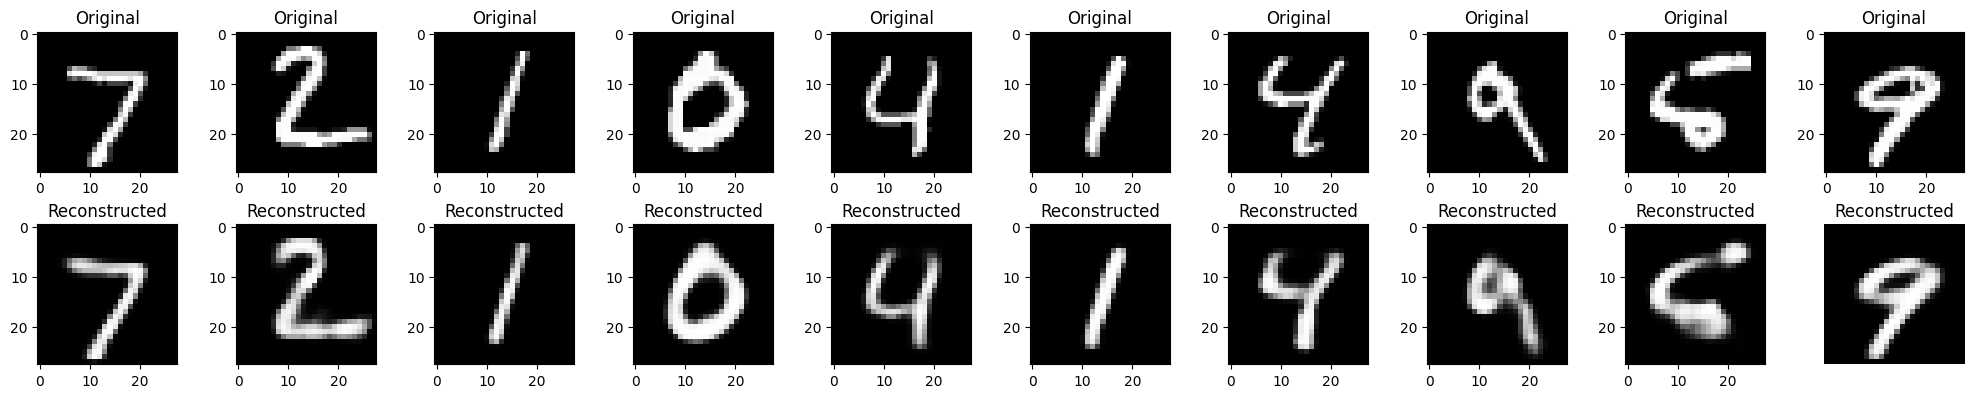

In [24]:
# Defines a dense autoencoder using TensorFlow/Keras to
# compress and reconstruct images from the MNIST dataset.

"""
Issues
1. Losses are much higher than in notebook
"""

import matplotlib.pyplot as plt#  type: ignore
import numpy as np#  type: ignore
import os
import pandas as pd#  type: ignore
from tensorflow import keras #  type: ignore
from tensorflow.keras.datasets import mnist   # type: ignore
from typing import Tuple, List, Any


class DenseAutoencoder(AbstractAutoencoder):
    def __init__(self, encode_dims: List[int], base_path: str=MODEL_DIR,
            is_delete_serializations: bool=True,
            activation: str ='sigmoid'):
        """Initializes the dense autoencoder.

        Args:
            encode_dims (List[int]): _description_
        """
        self.encode_dims = encode_dims
        self.num_hidden_layer = len(encode_dims) - 1
        self.activation = activation
        self.autoencoder, self.encoder, self.decoder, self.history_dct = self._build()
        super().__init__(base_path=base_path, is_delete_serializations=is_delete_serializations)

    def context_dct(self) -> dict:
        # Describes the parameters used to build the model.
        context_dct = {
            'encode_dims': self.encode_dims,
        }
        return context_dct

    def _build(self) -> Tuple[keras.Model, keras.Model, keras.Model, dict]:
        """Builds the autoencoder, encoder, and decoder models.

        Returns:
            Tuple[keras.Model, keras.Model, keras.Model]: The autoencoder, encoder, and decoder models.
        """
        # Keep this here since layers is also used as a variable name below
        from tensorflow.keras import layers #  type: ignore
        # Input layer
        input_img = keras.Input(shape=(self.encode_dims[0],))
        # Encoder
        encoded = None
        for idx in range(self.num_hidden_layer):
            if idx == 0:
                encoded = layers.Dense(self.encode_dims[1], activation=self.activation)(input_img) # type: ignore
            else:
                encoded = layers.Dense(self.encode_dims[idx+1], activation=self.activation)(encoded) # type: ignore
        # Decoder
        decode_dims = list(self.encode_dims)
        decode_dims.reverse()
        decoded = None
        for idx in range(self.num_hidden_layer):
            if idx == 0:
                decoded = layers.Dense(decode_dims[1], activation=self.activation)(encoded) # type: ignore
            else:
                decoded = layers.Dense(decode_dims[idx+1], activation=self.activation)(decoded) # type: ignore
        # Create the autoencoder model
        autoencoder = keras.Model(input_img, decoded)
        # Create encoder model (for extracting encoded representations)
        encoder = keras.Model(input_img, encoded)
        # Create the decoder model
        encoded_input = keras.Input(shape=(self.encode_dims[-1],))
        layers = []
        for idim in range(self.num_hidden_layer, 1, -1):
            layers.append(autoencoder.layers[-idim])
        decoder_layers = list(autoencoder.layers)[-(self.num_hidden_layer):]
        decoder_layer = encoded_input
        for layer in decoder_layers:
            decoder_layer = layer(decoder_layer)
        # Create decoder model
        decoder = keras.Model(encoded_input, decoder_layer)
        # Compile the autoencoder
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        return autoencoder, encoder, decoder, {}

    def _flatten(self, arr: np.ndarray) -> np.ndarray:
        """Flattens the input images.
        Args:
            x (np.ndarray): Input images (not flattened)

        Returns:
            np.ndarray: Flattened images
        """
        self.image_shape = np.shape(arr[0])
        size = np.prod(self.image_shape)
        num_image = np.shape(arr)[0]
        x_flat = arr.reshape(num_image, size).astype('float32')
        return x_flat
    
    def _unflatten(self, arr: np.ndarray) -> np.ndarray:
        """Flattens the input images.
        Args:
            x (np.ndarray): Input images (not flattened)

        Returns:
            np.ndarray: Flattened images
        """
        result_shape = np.zeros(len(self.image_shape) + 1)
        result_shape[0] = np.shape(arr)[0]
        result_shape[1:] = self.image_shape
        result = np.reshape(arr, result_shape.astype(int))
        return result

    def fit(self, 
            x_train: np.ndarray,
            num_epoch: int,
            batch_size: int,
            validation_data: np.ndarray,
            verbose: int=1) -> None:
        """Trains the autoencoder.
        Args:
            x_train (np.ndarray): Training data (not flattened)
            num_epoch (int): Number of training epochs
            batch_size (int): Size of training batches
            validation_data (np.ndarray): Validation data (not flattened)
            verbose (int, optional): Verbosity level. Defaults to 1.
        """
        # Flatten each image to a vector
        x_flat = self._flatten(x_train)
        test_flat = self._flatten(validation_data)
        super().fit(x_flat, num_epoch, batch_size, test_flat, verbose=verbose)

    
    def predict(self, image_arr: np.ndarray,
                predictor_type: str = "autoencoder") -> np.ndarray:
        """Generates reconstructed images from the autoencoder.

        Args:
            image_arr (np.ndarray): array of images
            predictor_type (str, optional):
                Type of predictor to use: "autoencoder", "encoder", or "decoder".
                Defaults to "autoencoder".

        Returns:
            np.ndarray: array of reconstructed images
        """
        if predictor_type in ["autoencoder", "encoder"]:
            image_arr = self._flatten(image_arr)
        predicted_arr = super().predict(image_arr, predictor_type=predictor_type)
        if predictor_type in ["autoencoder", "decoder"]:
            reconstructed_arr = self._unflatten(predicted_arr)
        else:
            reconstructed_arr = predicted_arr
        return reconstructed_arr
    
    @property
    def compression_factor(self) -> float:
        # Calculates the ratio between the original image size and the bottleneck size.
        # The bottleneck is determined by the last filter size and the downsampling factor.
        return self.encode_dims[0]/ self.encode_dims[-1]

# Tests
encode_dims = [784, 128, 64, 16]
dae = DenseAutoencoder(encode_dims, is_delete_serializations=True)
dae.fit(X_MNIST_TRAIN, num_epoch=1000, batch_size=128, validation_data=X_MNIST_TEST, verbose=1)
dae.summarize()
dae.plot(X_MNIST_TEST)

# Data Preparation

In [20]:
X_MNIST_TRAIN_FLAT = X_MNIST_TRAIN.reshape((len(X_MNIST_TRAIN), 28 * 28))
X_MNIST_TEST_FLAT = X_MNIST_TEST.reshape((len(X_MNIST_TEST), 28 * 28))
np.shape(X_MNIST_TRAIN_FLAT), np.shape(X_MNIST_TEST_FLAT)

((60000, 784), (10000, 784))

In [ ]:
_ = plt.hist(X_MNIST_TRAIN_FLAT)

# zip compression

zip compression is lossless. It is achieved by clever encoding of the data: Use the shortest encodings for values that occur most frequently.

In [21]:
compressed = zipCompressArray(X_MNIST_TRAIN_FLAT)  # See Helpers for this function
num_uncompressed_mbyte = X_MNIST_TRAIN_FLAT.nbytes/1e6
num_compressed_mbyte = len(compressed.getvalue())/1e6
print(f"Uncompressed size of MNIST training data: {num_uncompressed_mbyte} MB")
print(f"Compressed size of MNIST training data: {num_compressed_mbyte} MB")
print(f"Compression ratio: {num_uncompressed_mbyte/num_compressed_mbyte}")

Uncompressed size of MNIST training data: 47.04 MB
Compressed size of MNIST training data: 9.822183 MB
Compression ratio: 4.789159395625188


***Lossless compression provides a lower bound for dimension reduction.***

# Principal Component

* Lossy compression by extracting dominant effects
* Assumes linearity

In [22]:
def generatePCA(arr: np.ndarray, n_component: int) -> Tuple[np.ndarray, str]:
    pca = PCA(n_components=n_component, random_state=42)
    pca.fit(arr)
    x_reduced = pca.transform(arr)
    x_decoded = pca.inverse_transform(x_reduced)
    title = f"PCA/{n_component}"
    return x_decoded, title

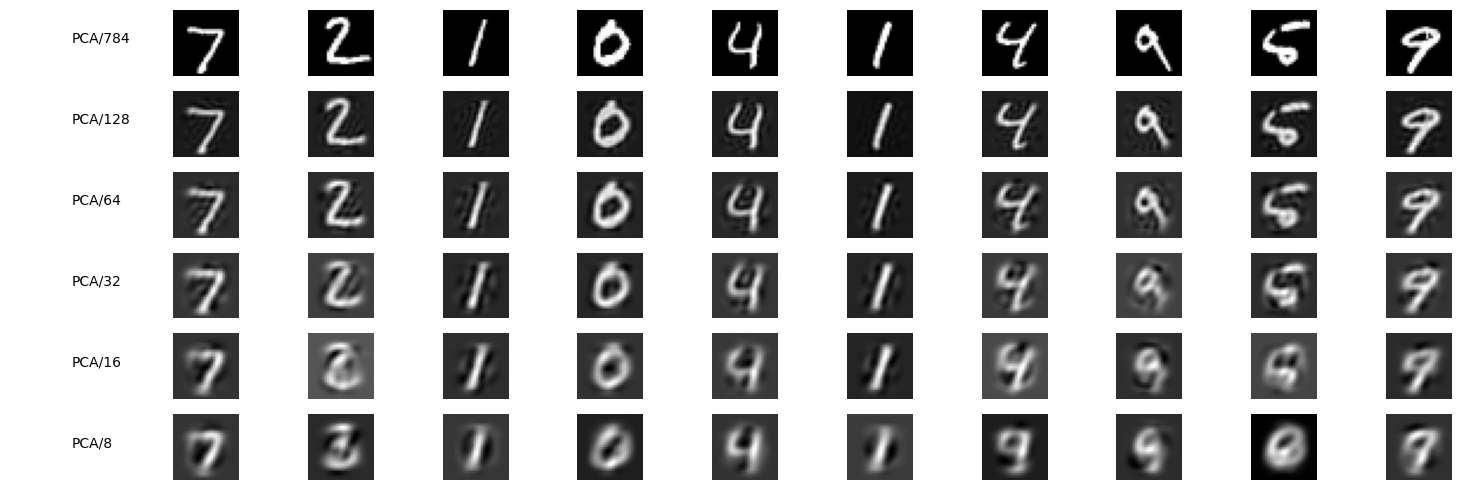

Compression ratios
784: 1.0
128: 6.125
64: 12.25
32: 24.5
16: 49.0
8: 98.0


In [23]:
sizes = [28*28, 128, 64, 32, 16, 8]
results = [generatePCA(X_MNIST_TEST_FLAT, n) for n in sizes]
arrs = [r[0] for r in results]
titles = [r[1] for r in results]
visualize(arrs, 10, titles=titles)
#
print("Compression ratios")
for size in sizes:
    print(f"{size}: {784/size}")

# Dense Autoencoder

## Normalize the data by dividing by the maximum value

In [ ]:
np.max(X_MNIST_TRAIN), np.max(X_MNIST_TEST)

## Implementing a dense autoencoder in Keras

## Evaluating compressions achieved

# Convolutional Autoencoder

In [ ]:
# Prepare the data
X_TRAIN, X_TEST = util.getPklMNIST()
# Reshape to add channel dimension (28, 28, 1) for CNN
X_TRAIN = np.expand_dims(X_TRAIN, -1)
X_TEST = np.expand_dims(X_TEST, -1)

print(f"Training data shape: {X_TRAIN.shape}")
print(f"Test data shape: {X_TEST.shape}")

In [ ]:
9*16

In [ ]:
# Define the Autoencoder

# Define convolutional autoencoder architecture
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

print(f"Encoded shape: {encoded.shape}")

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create encoder model (for extracting encoded representations)
encoder = keras.Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# Display model architecture
autoencoder.summary()

In [ ]:

# Train the autoencoder
history = autoencoder.fit(X_TRAIN, X_TRAIN,
                         epochs=1,
                         batch_size=128,
                         shuffle=True,
                         validation_data=(X_TEST, X_TEST),
                         verbose=1)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Generate predictions
encoded_imgs = encoder.predict(X_TEST)
decoded_imgs = autoencoder.predict(X_TEST)

print(f"Encoded representation shape: {encoded_imgs.shape}")

# Visualize some encoded feature maps
plt.subplot(1, 3, 3)
plt.imshow(encoded_imgs[0, :, :, 0], cmap='viridis')
plt.title('Encoded Feature Map (Channel 0)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Visualize original vs reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))

for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_TEST[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Difference (error map)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    diff = np.abs(X_TEST[i] - decoded_imgs[i])
    plt.imshow(diff.reshape(28, 28), cmap='hot')
    plt.title("Difference")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate reconstruction error statistics
mse = np.mean((X_TEST - decoded_imgs) ** 2)
mae = np.mean(np.abs(X_TEST - decoded_imgs))

print(f"\nReconstruction Statistics:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Analyze compression
original_size = 28 * 28 * 1  # 784 parameters per image
encoded_size = encoded_imgs.shape[1] * encoded_imgs.shape[2] * encoded_imgs.shape[3]
compression_ratio = original_size / encoded_size

print(f"\nCompression Analysis:")
print(f"Original image size: {original_size} pixels")
print(f"Encoded representation: {encoded_imgs.shape[1]}x{encoded_imgs.shape[2]}x{encoded_imgs.shape[3]} = {encoded_size} values")
print(f"Compression ratio: {compression_ratio:.1f}:1")

# Optional: Visualize learned filters from the first convolutional layer
def visualize_conv_filters(model, layer_idx=1, num_filters=16):
    """Visualize the learned convolutional filters"""
    filters = model.layers[layer_idx].get_weights()[0]

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f'Learned Filters from Layer {layer_idx}')

    for i in range(min(num_filters, 16)):
        ax = axes[i//4, i%4]
        ax.imshow(filters[:, :, 0, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize learned filters
visualize_conv_filters(autoencoder)

# Applications of Autoencoders

## Efficient classification

## Generation

### New bird

### Truck bird

# Animal Images

In [ ]:
data_dir = "/Users/jlheller/home/Technical/repos/pixel_proficiency/data/animals"
stl10 = datasets.STL10(root=data_dir, split='train', download=True)

In [ ]:
img = np.reshape(np.array(stl10[0][0]).flatten(), (96, 96, 3))
plt.imshow(np.array(img))

In [ ]:
img, label = stl10[100]
plt.imshow(np.array(img))
plt.title(f"Label: {label}")
plt.show()

In [ ]:
stl10_classes = [
    'airplane',
    'bird',
    'car',
    'cat',
    'deer',
    'dog',
    'horse',
    'monkey',
    'ship',
    'truck'
]

In [ ]:
num_row = 10
num_col = 10
_, axes = plt.subplots(num_row, num_col, figsize=(10, 15))
for irow in range(num_row):
    for icol in range(num_col):
        idx = irow*num_col + icol
        ax = axes[irow, icol]
        img, label = stl10[idx]
        ax.imshow(np.array(img))
        name = stl10_classes[int(label)]
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
        

## Convert to grey scale

In [ ]:
image, _ = stl10[0]
gray_img = image.convert('L')  
arr = np.array(gray_img)
np.shape(arr)
plt.imshow(arr)
plt.figure()
plt.imshow(np.array(image))

# Masked Autoencoder

In [ ]:
# Prepare the data
X_TRAIN, X_TEST = util.getPklMNIST()
# Reshape to add channel dimension (28, 28, 1) for CNN
X_TRAIN = np.expand_dims(X_TRAIN, -1)
X_TEST = np.expand_dims(X_TEST, -1)

print(f"Training data shape: {X_TRAIN.shape}")
print(f"Test data shape: {X_TEST.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf

# Load MNIST dataset
if False:
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    
    # Normalize to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Reshape to add channel dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
else:
    x_train = X_TRAIN
    x_test = X_TEST

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Masking function
def create_mask(batch_size, img_size=28, patch_size=4, mask_ratio=0.75):
    """
    Creates a random mask for patches.
    Args:
        batch_size: Number of images in batch
        img_size: Size of image (28 for MNIST)
        patch_size: Size of each patch
        mask_ratio: Ratio of patches to mask
    Returns:
        mask: Binary mask (1 = visible, 0 = masked)
    """
    num_patches = (img_size // patch_size) ** 2
    num_masked = int(mask_ratio * num_patches)
    
    masks = []
    for _ in range(batch_size):
        # Random indices to mask
        mask_indices = np.random.choice(num_patches, num_masked, replace=False)
        mask = np.ones(num_patches)
        mask[mask_indices] = 0
        masks.append(mask)
    
    return np.array(masks)

def apply_mask_to_image(images, masks, patch_size=4):
    """
    Applies patch-based mask to images.
    """
    batch_size = images.shape[0]
    img_size = images.shape[1]
    num_patches_side = img_size // patch_size
    
    masked_images = images.copy()
    
    for i in range(batch_size):
        mask = masks[i].reshape(num_patches_side, num_patches_side)
        for p_y in range(num_patches_side):
            for p_x in range(num_patches_side):
                if mask[p_y, p_x] == 0:
                    y_start = p_y * patch_size
                    x_start = p_x * patch_size
                    masked_images[i, y_start:y_start+patch_size, 
                                x_start:x_start+patch_size, :] = 0
    
    return masked_images

# Build Masked Autoencoder
def build_masked_autoencoder(input_shape=(28, 28, 1)):
    """
    Builds a convolutional masked autoencoder.
    """
    # Encoder
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Output layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Crop to match input size if needed
    decoded = layers.Cropping2D(cropping=((2, 2), (2, 2)))(decoded)
    
    autoencoder = keras.Model(inputs, decoded, name='masked_autoencoder')
    return autoencoder

# Create model
model = build_masked_autoencoder()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Data generator for training with random masking
class MaskedDataGenerator(keras.utils.Sequence):
    def __init__(self, x_data, batch_size=128, mask_ratio=0.75, patch_size=4):
        self.x_data = x_data
        self.batch_size = batch_size
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.indices = np.arange(len(x_data))
        
    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x_data[batch_indices]
        
        # Create masks and apply them
        masks = create_mask(len(batch_x), mask_ratio=self.mask_ratio, 
                          patch_size=self.patch_size)
        masked_x = apply_mask_to_image(batch_x, masks, patch_size=self.patch_size)
        
        return masked_x, batch_x  # Input: masked, Target: original
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Create data generators
train_gen = MaskedDataGenerator(x_train, batch_size=128, mask_ratio=0.75)
val_gen = MaskedDataGenerator(x_test, batch_size=128, mask_ratio=0.75)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    verbose=1
)

# Visualize results
def visualize_results(model, x_test, num_images=5, mask_ratio=0.75, patch_size=4):
    """
    Visualizes original, masked, and reconstructed images.
    """
    # Select random images
    indices = np.random.choice(len(x_test), num_images, replace=False)
    test_images = x_test[indices]
    
    # Create masks and masked images
    masks = create_mask(num_images, mask_ratio=mask_ratio, patch_size=patch_size)
    masked_images = apply_mask_to_image(test_images, masks, patch_size=patch_size)
    
    # Reconstruct
    reconstructed = model.predict(masked_images, verbose=0)
    
    # Plot
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 3*num_images))
    
    for i in range(num_images):
        # Original
        axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # Masked
        axes[i, 1].imshow(masked_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Masked ({int(mask_ratio*100)}%)')
        axes[i, 1].axis('off')
        
        # Reconstructed
        axes[i, 2].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Reconstructed')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(model, x_test, num_images=5, mask_ratio=0.75)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Notes

1. Do classification using encoded representation to reduce computation cost
2. Consider doing the autoencoding on the zip data
3. Tuning hyperparameters: batch size, number of epochs, activation (use same for each step?)
4. Using GPU
5. Debugging quality - what layers? what activations?
6. Choice of objective function.
7. Debugging layer shapes
8. Data preparation
9.   1. Normalize to create values between 0 and 1
10. Design
11.   1. Be consistent on the activations. If an encoder layer uses 'relu', the corresponding decoder layer should as well.
12. Tuning
13.  1. Need enough batches of sufficient size, approx 100. At least 30-40 batches
14.  2. Start with less compression and then go to more
15. Pro tips
    1. ``EarlyStopping``
    2. ``ReduceLROnPlateau``
    3. ``ModelCheckpoint``